In [1]:
import numpy as np
from datetime import datetime
import h5py

from dabry.problem import DatabaseProblem
from dabry.ddf_manager import DDFmanager
from dabry.misc import Utils, Chrono
from dabry.solver_ef import SolverEF
from dabry.penalty import CirclePenalty, DiscretePenalty

In [2]:
penalty = DiscretePenalty()
penalty.load('test_smooth_frozen.h5')
penalty.value(datetime(2020, 7, 15, 18, 0).timestamp(), Utils.DEG_TO_RAD * np.array((-25, 15)))

array([4.37630194e-05])

In [72]:
import matplotlib.pyplot as plt
nx, ny = 40, 50
vals = np.zeros((nx, ny))
dvals = np.zeros((nx, ny, 2))
lons = np.linspace(-40, -10, nx)
lats = np.linspace(-10, 20, ny)
m_norm = 0.
for i, lon in enumerate(lons):
    for j, lat in enumerate(lats):
        args = datetime(2020, 7, 15, 10, 0).timestamp(), Utils.DEG_TO_RAD * np.array((lon, lat))
        dvals[i, j] = penalty.d_value(*args)
        vals[i, j] = penalty.value(*args)
        norm = np.linalg.norm(t[i,j])
        if norm > m_norm:
            m_norm = norm

In [83]:
m_norm

0.9176960535227546

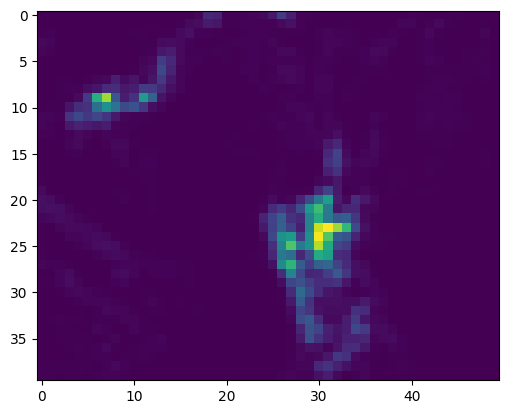

In [73]:
plt.imshow(vals)

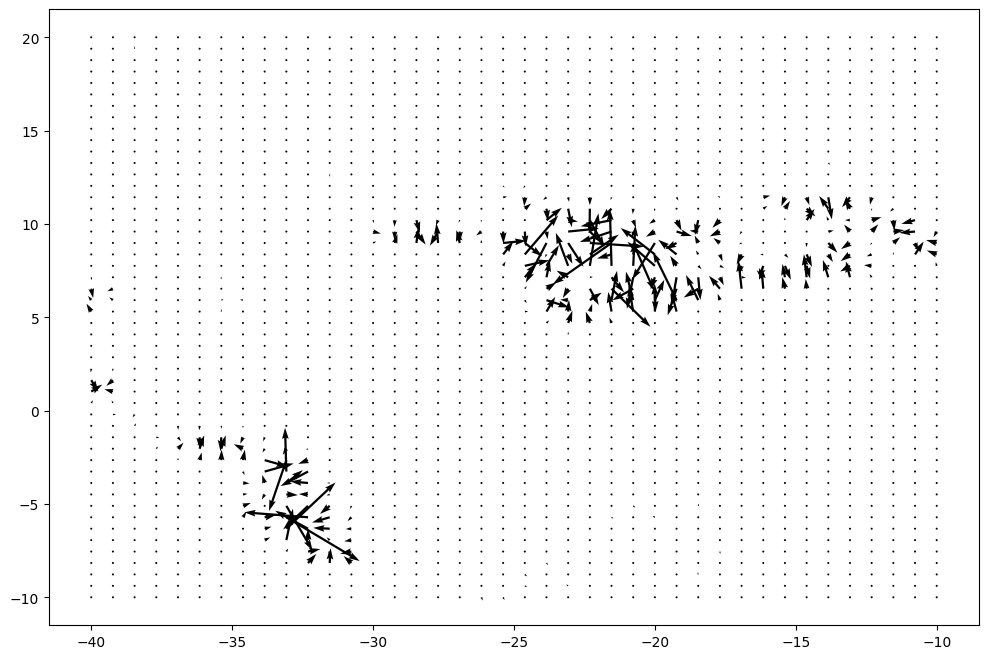

In [75]:
lls, llt = np.meshgrid(lons, lats, indexing='ij')
fig, ax = plt.subplots(figsize=(12,8))
plt.quiver(lls, llt, dvals[..., 0], dvals[..., 1], scale=10)

In [27]:
t[:, :, 0].shape

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## Modify penalty to sum in 3 hours

In [10]:
with h5py.File('test_smooth.h5', 'r') as f:
    with h5py.File('test_smooth_frozen.h5', 'w') as f_smooth:
        f_smooth.create_dataset('grid', f['grid'].shape)
        f_smooth['grid'][:] = f['grid']
        f_smooth.create_dataset('ts', (2,))
        f_smooth['ts'][0] = f['ts'][0]
        f_smooth['ts'][1] = f['ts'][-1]
        nt, nx, ny = f['data'].shape
        f_smooth.create_dataset('data', (2, nx, ny))
        f_smooth['data'][0, :] = f['data'][10]
        f_smooth['data'][1, :] = f['data'][10]

In [3]:
x_init = Utils.DEG_TO_RAD * np.array((-17.46, 14.71)) # Dakar
x_target = Utils.DEG_TO_RAD * np.array((-35.26, -5.81)) # Natal
start_date = datetime(2020, 7, 15, 0, 0)
airspeed = 23
level = '1000'

duration = 2 * Utils.distance(x_init, x_target,
                              coords=Utils.COORD_GCS) / airspeed
stop_date = datetime.fromtimestamp(start_date.timestamp() + duration)

ddf = DDFmanager()
ddf.setup()

ddf.retrieve_wind(start_date, stop_date, level=level, res='0.5')
case_name = ddf.format_cname(x_init, x_target, start_date.timestamp())

cache_wind = False
cache_rff = False

# This instance prints absolute elapsed time between operations
chrono = Chrono()

# Create a file manager to dump problem data
mdfm = DDFmanager(cache_wind=cache_wind, cache_rff=cache_rff)
mdfm.setup()
case_name = f'test_penalty_real'
mdfm.set_case(case_name)
mdfm.clean_output_dir()

# Space and time discretization
# Will be used to save wind when wind is analytical and shall be sampled
# Will also be used by front tracking module
nx_rft = 101
ny_rft = 101
nt_rft = 20

pb = DatabaseProblem(x_init=x_init,
                     x_target=x_target, airspeed=airspeed,
                     t_start=start_date.timestamp(), t_end=stop_date.timestamp(),
                     altitude=level,
                     resolution='0.5')
pb.model.wind.value = lambda t, x : np.zeros(2)
pb.model.wind.d_value = lambda t, x : np.zeros((2,2))

pb.penalty = DiscretePenalty(0.005* penalty.data, penalty.ts, penalty.grid)
#with h5py.File('data/cds/0.5/1000/20210930.grib2', 'r') as f:
#    penalty = DiscretePenalty()

# pb.flatten()

if not cache_wind:
    chrono.start('Dumping windfield to file')
    mdfm.dump_wind(pb.model.wind, nx=nx_rft, ny=ny_rft, nt=nt_rft, bl=pb.bl, tr=pb.tr)
    chrono.stop()

# Setting the extremal solver
solver_ef = SolverEF(pb, pb.time_scale, max_steps=700, rel_nb_ceil=0.02, quick_solve=True)

chrono.start('Solving problem using extremal field (EF)')
res_ef = solver_ef.solve()
chrono.stop()
if res_ef.status:
    # Solution found
    # Save optimal trajectory
    mdfm.dump_trajs([res_ef.traj])
    print(f'Target reached in : {Utils.time_fmt(res_ef.duration)}')
else:
    print('No solution found')

# Save extremal field for display purposes
extremals = solver_ef.get_trajs()
mdfm.dump_trajs(extremals)

'''
pb.penalty = DiscretePenalty(0.001 * penalty.data, penalty.ts, penalty.grid)
solver_ef = SolverEF(pb, pb.time_scale, max_steps=700, rel_nb_ceil=0.02, quick_solve=True)
chrono.start('Solving problem using extremal field (EF)')
res_ef = solver_ef.solve()
chrono.stop()
if res_ef.status:
    # Solution found
    # Save optimal trajectory
    mdfm.dump_trajs([res_ef.traj])
    print(f'Target reached in : {Utils.time_fmt(res_ef.duration)}')
else:
    print('No solution found')
'''

pb.orthodromic()
mdfm.dump_trajs([pb.trajs[-1]])
mdfm.dump_penalty(pb.penalty)
mdfm.log(pb)

Wind fully in cache (20200715 00:00 to 20200718 00:46)


100%|███████████████████████████████████████████| 62/62 [00:03<00:00, 17.16it/s]


[*] Dumping windfield to file
[*] Done (0.01s)
[*] Solving problem using extremal field (EF)
Problem | TIMEOPT | 23.00 m/s | 3.01e+06 m | scale 36h23m | orthodromic 36h1m
Steps :     96/700, Extremals :   3925, Active : 2317, Dist :   2 Stopped quick solve
Target reached in 35h45m | -1% no wind | +0% orthodromic | cpu time 86.81s
[*] Done (87.06s)
Target reached in : 35h45m
